In [1]:
%matplotlib inline
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm
import seaborn as sns

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
data = pd.read_csv("./data/rt_tidy.csv")
data.head(10)

,Unnamed: 0,X.1,language,user_id,trait,stim_id,order,rt,rating,country,...,ethnicity.x,lab,block,X,Race,Gender,Age,ethnicity.y,gender,log_rt
0,1,606711,SPA,9654,confident,BM-040,41,1903,3,CO,...,NaN,COL_004,2,51,B,M,26.952381,black,male,7.551187
1,2,331376,HU,5381,responsible,WF-015,33,799,7,HU,...,"magyar, kaukázusi",HUN_001,2,93,W,F,24.211111,white,female,6.683361
2,3,162777,ENG,2734,attractive,LF-208,14,1226,1,US,...,Hispanic,USA_038,2,63,L,F,24.642857,latinx,female,7.111512
3,4,614094,SPA,9753,caring,BF-008,67,4561,7,CO,...,ninguno,COL_004,1,35,B,F,24.574713,black,female,8.425297
4,5,732055,PT,11726,aggressive,BF-201,36,912,3,PT,...,Caucasiana,POR_001,2,40,B,F,27.400000,black,female,6.815640
5,6,353796,ENG,5692,attractive,BF-047,105,1446,1,AU,...,Caucasian,AUS_007,1,39,B,F,34.213483,black,female,7.276556
6,7,437062,ENG,6884,mean,WM-256,73,1991,1,CA,...,South Asian,CAN_018,1,120,W,M,30.961538,white,male,7.596392
7,8,88967,ENG,1541,old,BF-004,3,1437,4,US,...,White,USA_113,2,32,B,F,26.983696,black,female,7.270313
8,9,438455,ENG,6897,caring,LM-243,63,2546,6,CA,...,white,CAN_018,2,86,L,M,21.642857,latinx,male,7.842279
9,10,701944,ENG,11134,aggressive,LM-219,13,1629,2,US,...,white,USA_054,1,81,L,M,26.703704,latinx,male,7.395722


# Preprocess

In [12]:
# create the new column that uses centralized rating
data['ratingcen'] = (data['rating'] - 5).abs() + 1

data['region'] = data['lab'].str[:-4]

data.head(10)

,Unnamed: 0,X.1,language,user_id,trait,stim_id,order,rt,rating,country,...,block,X,Race,Gender,Age,ethnicity.y,gender,log_rt,ratingcen,region
0,1,606711,SPA,9654,confident,BM-040,41,1903,3,CO,...,2,51,B,M,26.952381,black,male,7.551187,3,COL
1,2,331376,HU,5381,responsible,WF-015,33,799,7,HU,...,2,93,W,F,24.211111,white,female,6.683361,3,HUN
2,3,162777,ENG,2734,attractive,LF-208,14,1226,1,US,...,2,63,L,F,24.642857,latinx,female,7.111512,5,USA
3,4,614094,SPA,9753,caring,BF-008,67,4561,7,CO,...,1,35,B,F,24.574713,black,female,8.425297,3,COL
4,5,732055,PT,11726,aggressive,BF-201,36,912,3,PT,...,2,40,B,F,27.400000,black,female,6.815640,3,POR
5,6,353796,ENG,5692,attractive,BF-047,105,1446,1,AU,...,1,39,B,F,34.213483,black,female,7.276556,5,AUS
6,7,437062,ENG,6884,mean,WM-256,73,1991,1,CA,...,1,120,W,M,30.961538,white,male,7.596392,5,CAN
7,8,88967,ENG,1541,old,BF-004,3,1437,4,US,...,2,32,B,F,26.983696,black,female,7.270313,2,USA
8,9,438455,ENG,6897,caring,LM-243,63,2546,6,CA,...,2,86,L,M,21.642857,latinx,male,7.842279,2,CAN
9,10,701944,ENG,11134,aggressive,LM-219,13,1629,2,US,...,1,81,L,M,26.703704,latinx,male,7.395722,4,USA


# Hierarchical bayeisan model

In [13]:
data['ratingcen'] = (data['rating'] - 5).abs() + 1

data['region'] = data['lab'].str[:-4]


# Filter rows based on rating
data2 = data[(data['ratingcen'] == 2) | (data['ratingcen'] == 5)]


In [142]:

region_idxs, region = pd.factorize(data2.region)
stim_idxs, stim_id = pd.factorize(data2.stim_id)
num_regions = len(data["region"].unique())
num_stims = len(data["stim_id"].unique())
coords = {
    "region": region,
    "region_id": np.arange(len(region_idxs)),
    'stim_id': stim_id,
    "stim_idx": np.arange(len(stim_idxs)),
}

with pm.Model(coords = coords) as model_ExGaussian3:

    # 定义先验分布
    region_sd = pm.HalfNormal('region_sd', sd = 50)    #region截距的先验
    stim_id_sd = pm.HalfNormal('stim_id_sd', sd = 50)  #stim截距的先验
    rt_coeff = pm.Normal('rt_coeff', mu=0, sd=1)       #自变量系数的先验

    # 定义分层的随机效应
    region_effects = pm.Normal('region_effects', mu=50, sd=region_sd, shape = num_regions)      #region效应
    stim_id_effects = pm.Normal('stim_id_effects', mu=50, sd=stim_id_sd, shape = num_stims)  #stim效应

    #rt的先验分布
    rt_nu = pm.HalfNormal('rt_nu', 100)
    rt_sigma = pm.HalfNormal('rt_sigma', 100)
    rt_mu = pm.Normal('rt_mu', mu = 1700, sd = 1000)
    rt = pm.ExGaussian('rt', mu=rt_mu, sigma=rt_sigma, nu = rt_nu, observed=data2.rt)

    # 计算预测的响应时间
    rating_mu = pm.Deterministic('mu',region_effects[region_idxs] + stim_id_effects[stim_idxs] + rt*rt_coeff)

    # 定义观测变量
    sigma = pm.HalfNormal('sigma', sd = 100)
    rt = pm.Normal('rating', mu=rating_mu, sigma = sigma, observed = data2.ratingcen)


d:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


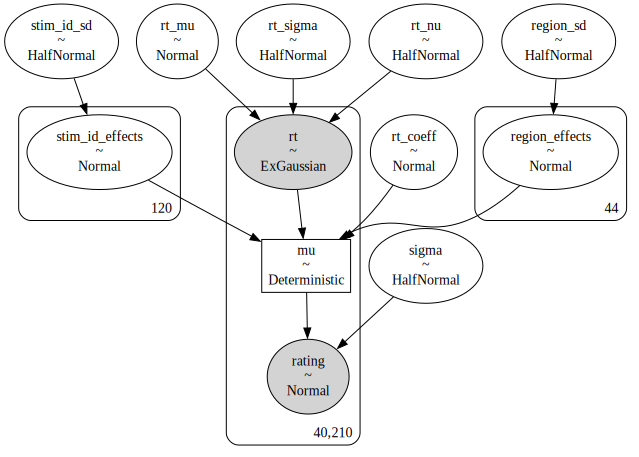

In [143]:
pm.model_to_graphviz(model_ExGaussian3)

In [107]:
# 检查先验

with model_ExGaussian3:
    prior_checks = pm.sample_prior_predictive(samples=50)

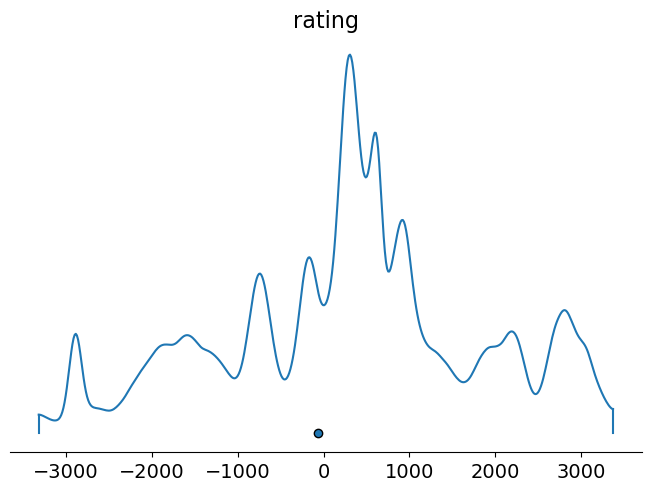

In [ ]:
az.plot_density(
    {'rating':prior_checks['rating']}
    )
plt.show()

d:\Anaconda\lib\site-packages\arviz\stats\density_utils.py:606: UserWarning: Something failed: `x` does not contain any finite number.
  warnings.warn("Something failed: " + str(e))


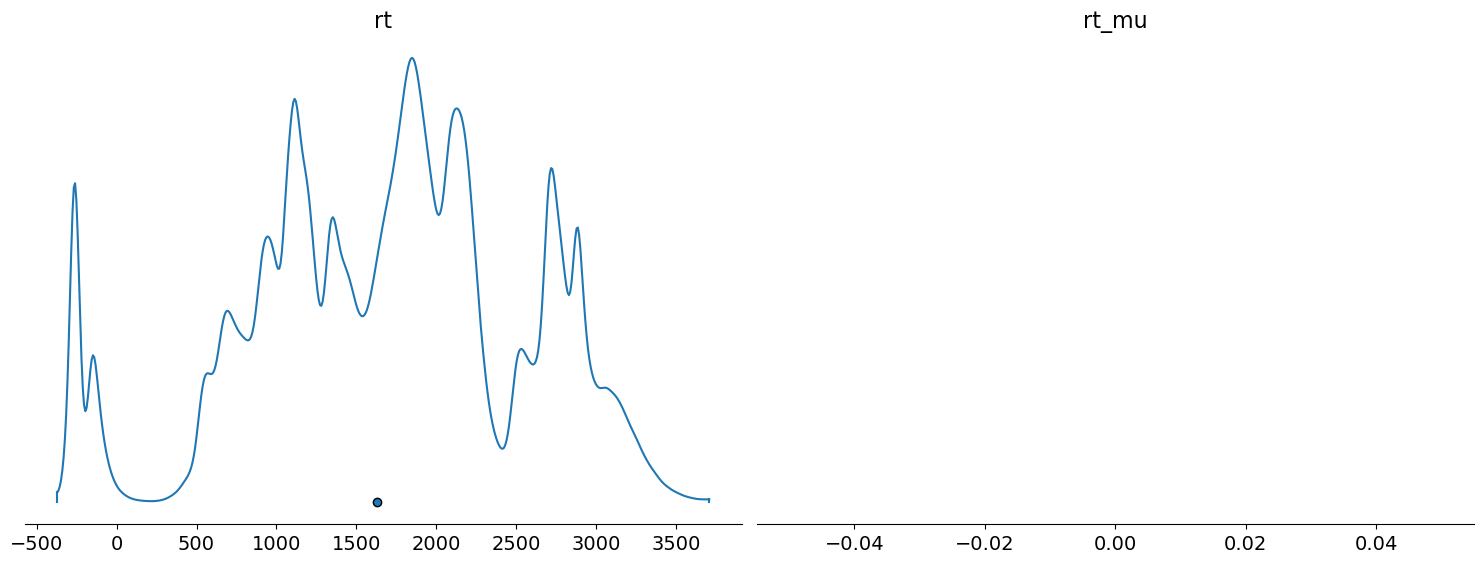

In [84]:
az.plot_density(
    {
        'rt': prior_checks['rt'],
        'rt_mu': prior_checks['rt_mu']
    }
    )
plt.show()

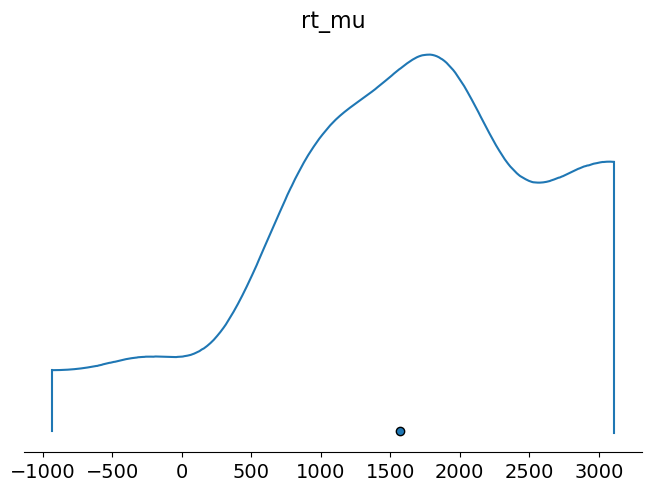

In [85]:
az.plot_density(
    {'rt_mu': prior_checks['rt_mu']
    }
    )
plt.show()

In [126]:
#MCMC sampling
with model_ExGaussian3:
    trace_ExGaussian3 = pm.sample(draws = 2000, tune= 500, target_accept=0.8, chains=2, cores= 2,return_inferencedata=True)

d:\Anaconda\lib\site-packages\theano\scalar\basic.py:3023: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
d:\Anaconda\lib\site-packages\theano\scalar\basic.py:3023: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
d:\Anaconda\lib\site-packages\theano\scalar\basic.py:3023: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
d:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
d:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
d:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
d:\Anaconda\lib\site-packages\theano\tensor\e

ValueError: Not enough samples to build a trace.

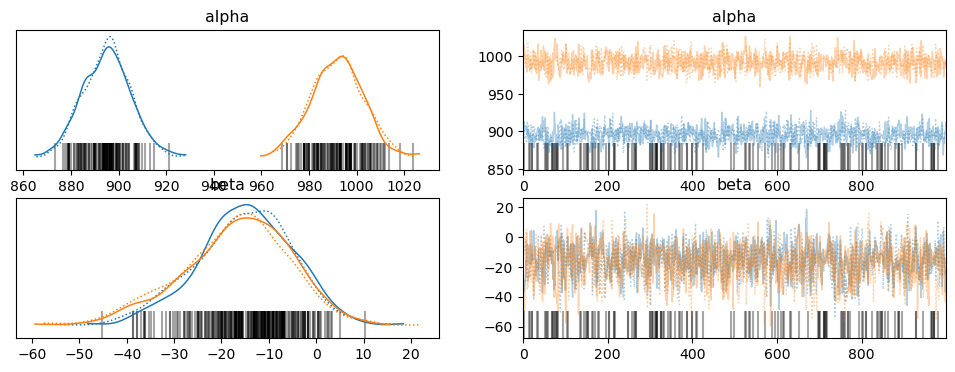

In [ ]:
az.plot_trace(trace_ExGaussian3, var_names=['region_effects','rt_coeff','stim_id_effects'])#分开呈现
plt.show()

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

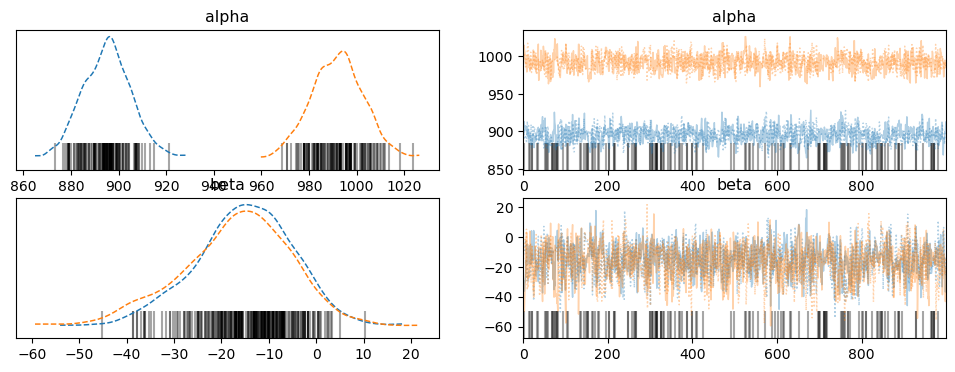

In [20]:
az.plot_trace(trace_ExGaussian3, var_names=['alpha','beta'], combined=True)

In [28]:
# Obtain posterior distribution for the effect of semantic relatedness
semantic_effect = trace_ExGaussian3['beta']

# Calculate mean and credible interval for the effect of semantic relatedness
#semantic_mean = np.mean(semantic_effect)
#semantic_ci = pm.stats.hpd(semantic_effect, credible_interval=0.95)
#print("Mean of the effect of semantic relatedness:", semantic_mean)
#print("95% credible interval of the effect of semantic relatedness:", semantic_ci)


KeyError: 'beta'

In [21]:
az.summary(trace_ExGaussian3, var_names=['alpha','beta'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[yes],895.218,10.091,875.519,912.978,0.349,0.247,834.0,1037.0,1.0
alpha[no],992.009,10.768,971.523,1011.858,0.355,0.251,917.0,918.0,1.0
beta[yes],-15.164,10.231,-34.971,3.271,0.355,0.255,833.0,991.0,1.0
beta[no],-16.998,11.565,-39.944,2.828,0.457,0.323,662.0,1123.0,1.0


In [22]:
with model_ExGaussian3:
    #计算后验预测分布
    ppc_y = pm.sample_posterior_predictive(trace_ExGaussian3.posterior) 
#将ppc_y转化为InferenceData对象合并到trace中
az.concat(trace_ExGaussian3, az.from_pymc3(posterior_predictive=ppc_y), inplace=True)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nanwang/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


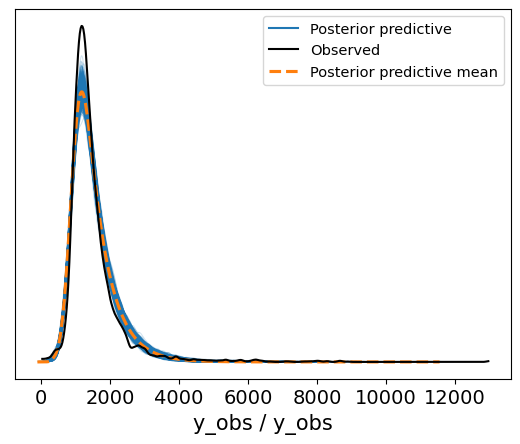

In [23]:
az.plot_ppc(trace_ExGaussian3)
plt.show()

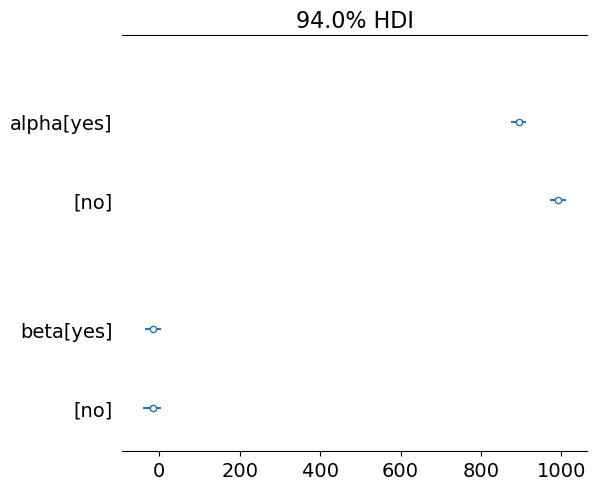

In [25]:
az.plot_forest(trace_ExGaussian3, var_names=['alpha', 'beta'], combined=True);
